# Packages

In [180]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast
import math

import pandas as pd
import geopandas as gpd
import numpy as np

# Loading data

In [181]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [182]:
football = pd.read_csv(RAW_DIR / "football_new.csv")

# Exporatory Data Analysis

In [183]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_key_pass_id,', 'shot_one_on_one'],
      dtype='object')

In [184]:
football["shot_type"].value_counts()

shot_type
Open Play    43096
Free Kick     2124
Penalty        486
Corner          13
Name: count, dtype: int64

In [185]:
football.groupby(["shot_type"])["shot_outcome"].count()

shot_type
Corner          13
Free Kick     2124
Open Play    43096
Penalty        486
Name: shot_outcome, dtype: int64

Are we going to look at all the periods? Overtime and also penalty kick?

In [186]:
football["period"].value_counts().sort_index()

period
1    20814
2    24905
Name: count, dtype: int64

I am gonna transform shot outcome column into a 0 and 1 column

In [187]:
football["shot_outcome"].unique().tolist()

['Off T',
 'Goal',
 'Blocked',
 'Saved',
 'Wayward',
 'Post',
 'Saved Off Target',
 'Saved to Post']

I will transform timestamp into a minute ceil column (e.g., 4:32 -> 5th minute)

In [188]:
football["timestamp"].unique()

array(['00:04:21.052', '00:06:27.395', '00:08:16.762', ...,
       '00:45:24.473', '00:45:25.517', '00:47:47.998'],
      shape=(45346,), dtype=object)

I will transform location to a x and y column by making it a list first

In [189]:
football["location"].head()

0    [108.1, 31.2]
1    [110.9, 42.6]
2    [117.9, 29.1]
3    [101.8, 27.6]
4    [109.3, 26.5]
Name: location, dtype: object

<Axes: xlabel='shot_body_part'>

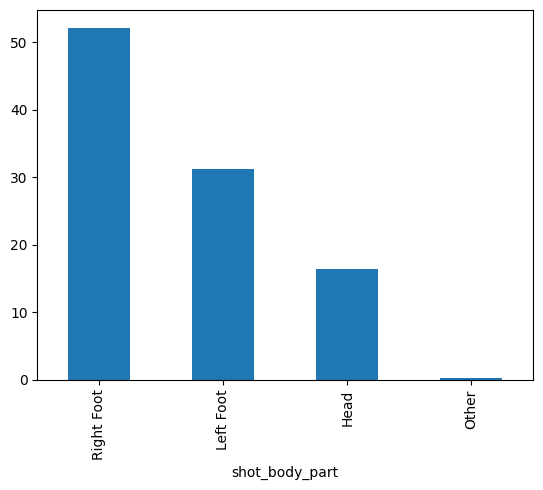

In [190]:
(football["shot_body_part"].value_counts(normalize=True) * 100).plot(kind='bar')

There is no freeze frame data for penalty kicks which makes sense

In [191]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    434
Name: count, dtype: int64

In [192]:
football["shot_outcome"].value_counts()

shot_outcome
Off T               15089
Blocked             11292
Saved               10744
Goal                 4706
Wayward              2704
Post                  870
Saved Off Target      161
Saved to Post         153
Name: count, dtype: int64

# Processing Data

In [193]:
def process_shot_outcome(df):
    outcome_mapping = {
        'Off T': 0,
        'Goal': 1,
        'Blocked': 0,
        'Saved': 0,
        'Wayward': 0,
        'Post': 0,
        'Saved Off Target': 0,
        'Saved to Post': 0
    }

    df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
    return df

def process_shot_body_part(df, add_combine_feet=True):
    dummies = pd.get_dummies(df['shot_body_part'], prefix='body_part', drop_first=False, dtype=int)
    dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")

    if add_combine_feet:
        dummies['body_part_foot'] = dummies.get('body_part_left_foot', 0) + dummies.get('body_part_right_foot', 0)
        dummies.drop(columns=['body_part_left_foot', 'body_part_right_foot'], inplace=True)

    df = pd.concat([df, dummies], axis=1)
    return df

def process_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
    df['time_only'] = df['timestamp'].dt.time
    df['minute'] = df['timestamp'].dt.minute # maybe remove?
    df['second'] = df['timestamp'].dt.second # maybe remove?
    df['minute_ceil'] = df['timestamp'].dt.ceil('min').dt.minute
    return df

def process_location(df):
    df["location"] = df['location'].apply(ast.literal_eval)
    df[["x", "y"]] = pd.DataFrame(df["location"].tolist(), index=df.index)
    return df

def distance_from_goal(df):
    df['distance_from_goal_center'] = np.sqrt((120 - df['x'])**2 + (40 - df['y'])**2) # need to double check
    df['distance_from_goal_left_post'] = np.sqrt((120 - df['x'])**2 + (36 - df['y'])**2)
    df['distance_from_goal_right_post'] = np.sqrt((120 - df['x'])**2 + (44 - df['y'])**2)

    return df

def process_one_hot_encoding(df, cols_to_process):
    # one hot encoding
    for col in cols_to_process:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False, dtype=int)
        dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")
        df = pd.concat([df, dummies], axis=1)
    return df

def encode_true_false(df, cols_to_process):
    # Convert True into 1 and NaN into 0
    for col in cols_to_process:
        df[col] = df[col].fillna(False).astype(int)
    return df


def shot_angle(x, y, 
               post1=(120, 36),   # top post
               post2=(120, 44)):  # bottom post
    """
    Returns shot angle in radians using absolute difference of atan2 angles.
    x, y: shooter coordinates.
    post1, post2: (x,y) of both posts.
    """
    a1 = math.atan2(post1[1] - y, post1[0] - x)
    a2 = math.atan2(post2[1] - y, post2[0] - x)
    return abs(a2 - a1)


def get_opposition_goalkeeper_location(freeze_frame):
    """
    Returns the location of the opposition goalkeeper
    (position='Goalkeeper' and teammate=False).
    """

    for player in freeze_frame:
        if (
            player.get("position", {}).get("name") == "Goalkeeper"
            and player.get("teammate") is False
        ):
            location = player.get("location")
            return location
        
    return None

drop penalties columns

In [194]:
football["shot_type"].unique()

array(['Open Play', 'Free Kick', 'Penalty', 'Corner'], dtype=object)

In [195]:
# keep only open play or free kick
football = football[(football["shot_type"] == "Open Play") | (football["shot_type"] == "Free Kick")]

# 

In [ ]:
football = process_shot_outcome(football)
football = process_timestamp(football)
football = process_location(football)
football = distance_from_goal(football)
football = process_shot_body_part(football, True)
football = encode_true_false(football, ["shot_open_goal", "under_pressure", "shot_deflected", "shot_one_on_one", "shot_first_time"])
football = process_one_hot_encoding(football, ["shot_technique", "play_pattern", "shot_type"]) # removed position
football["shot_freeze_frame"] = football["shot_freeze_frame"].apply(ast.literal_eval)
football["goalkeeper_location"] = football["shot_freeze_frame"].apply(get_opposition_goalkeeper_location)
football["shot_angle"] = football.apply(lambda row: shot_angle(row["x"], row["y"]), axis=1)


# show all columns
pd.set_option('display.max_columns', None)


/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_2450/883182806.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(int)
/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_2450/883182806.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(int)
/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_2450/883182806.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.

In [ ]:
football[football["goalkeeper_location"].isna()]

,id,index,match_id,period,timestamp,second,minute,team,team_id,player,player_id,position,play_pattern,type,under_pressure,shot_deflected,shot_open_goal,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,shot_first_time,shot_technique,"shot_key_pass_id,",shot_one_on_one,shot_outcome_encoded,time_only,minute_ceil,x,y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_location,shot_angle,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_techniqu

In [ ]:
football.to_csv(PROCESSED_DIR / "football_processed.csv", index=False)